In [31]:
import cv2, mmcv
from tqdm.notebook import tqdm
from EasyMTCNN import EasyMTCNN
from EasyBlazeFace import EasyBlazeFace
from EasyDSFD import EasyDSFD
from EasyLightDSFD import EasyLightDSFD
from EasyRetinaFace import EasyRetinaFace

from IPython.display import *
import time
from fastai.core import *
from fastai.vision import *
from kgl_deepfake.data import *
from kgl_deepfake.video_compression import *

## Find hard examples

In [2]:
dfdcs = ['train_sample_videos', 'dfdc_train_part_0', 'dfdc_train_part_5', 'dfdc_train_part_10']
dfdcs = [f'{o}_fps15' for o in dfdcs]

In [3]:
source = Path('../data')

In [4]:
annots = load_dfdc_json(source, dfdcs[3], fpath=True, drop_missing=True)
annots.head()

fname label  split  \
0  ../data/dfdc_train_part_10_fps15/hsypgwsufp.mp4  FAKE  train   
1  ../data/dfdc_train_part_10_fps15/ntzgbkzofo.mp4  FAKE  train   
2  ../data/dfdc_train_part_10_fps15/ataulynpgd.mp4  FAKE  train   
3  ../data/dfdc_train_part_10_fps15/idzntwkkjy.mp4  FAKE  train   
4  ../data/dfdc_train_part_10_fps15/rdqokuannd.mp4  FAKE  train   

                                          original  
0  ../data/dfdc_train_part_10_fps15/nbnipejygk.mp4  
1  ../data/dfdc_train_part_10_fps15/cqlarprtdy.mp4  
2  ../data/dfdc_train_part_10_fps15/uzrkbzwdvi.mp4  
3  ../data/dfdc_train_part_10_fps15/lvnjzrvzwy.mp4  
4  ../data/dfdc_train_part_10_fps15/mujubwlspn.mp4

In [5]:
fns = list(annots.fname.sample(10))

In [6]:
HTML(html_vids(fns, titles=fns))

In [7]:
annots[annots.fname==Path('../data/dfdc_train_part_10_fps15/ckzxyuvowt.mp4')]

fname label  split  \
830  ../data/dfdc_train_part_10_fps15/ckzxyuvowt.mp4  FAKE  train   

                                            original  
830  ../data/dfdc_train_part_10_fps15/ruraoelttp.mp4

Gather hard examples for benchmarking.

In [8]:
FDSample = namedtuple('FDSample', ['description', 'path', 'nface'])

In [39]:
named_videos = [
    FDSample('side_profile_fake', '../data/dfdc_train_part_0/bwsytelwkm.mp4', 1),
    FDSample('side_profile_real', '../data/dfdc_train_part_0/fsaronfupy.mp4', 1),
    FDSample('two_people_fake', '../data/dfdc_train_part_10/raiqyyzhrw.mp4', 2),
    FDSample('two_people_real', '../data/dfdc_train_part_10/tvivejpzsc.mp4', 2),
    FDSample('dark_scene_fake', '../data/train_sample_videos/cycacemkmt.mp4', 1),
    FDSample('dark_scene_real', '../data/train_sample_videos/atvmxvwyns.mp4', 1),
    FDSample('moving_fake', '../data/dfdc_train_part_5/lrhwwlrhjc.mp4', 1),
    FDSample('moving_real', '../data/dfdc_train_part_5/kmigcpmqoq.mp4', 1),
    FDSample('obscured_face_fake1', '../data/dfdc_train_part_10/qfpurllewq.mp4', 1),
    FDSample('obscured_face_fake2', '../data/dfdc_train_part_5/wdfyezgwlx.mp4', 1),
    FDSample('obscured_face_fake3', '../data/dfdc_train_part_5/smcelxixcs.mp4', 1),
    FDSample('obscured_face_fake4', '../data/dfdc_train_part_5/ofxjoeebby.mp4', 1),
    FDSample('obscured_face_fake5', '../data/dfdc_train_part_5/eiwamqjboa.mp4', 1),
    FDSample('two faces', '../data/dfdc_train_part_10/ckzxyuvowt.mp4', 2)]

In [40]:
def append_to_parent(path, label):
    path = Path(path)
    return str(Path(f'{path.parent}_{label}')/path.name)

In [41]:
named_videos = [FDSample(o.description, append_to_parent(o.path, 'fps15'), o.nface) for o in named_videos]


In [42]:
df = pd.DataFrame(named_videos)
df.head()

description                                              path  nface
0  side_profile_fake    ../data/dfdc_train_part_0_fps15/bwsytelwkm.mp4      1
1  side_profile_real    ../data/dfdc_train_part_0_fps15/fsaronfupy.mp4      1
2    two_people_fake   ../data/dfdc_train_part_10_fps15/raiqyyzhrw.mp4      2
3    two_people_real   ../data/dfdc_train_part_10_fps15/tvivejpzsc.mp4      2
4    dark_scene_fake  ../data/train_sample_videos_fps15/cycacemkmt.mp4      1

In [43]:
def descrip2path(description): 
    return df.path[df.description==description].values[0]

In [44]:
def plot_detections(img, detections, with_keypoints=True, figsize=(10,10)):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    print("Found %d faces" % len(detections))
        
    for i in range(len(detections)):
        
        xmin = detections[i, 0]
        ymin = detections[i, 1]
        xmax = detections[i, 2]
        ymax = detections[i, 3]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        
    plt.show()

## Face Detection Algorithms

Each face detection algorithm has a `.detect()` method that accepts a frame and returns a numpy array containing one or more detection. Each detecion is formatted as:

`x_min, y_min, x_max, y_max, probability`

This was the most common format so we've changed a few implementations to mimic it.

In [52]:
vid = mmcv.VideoReader(descrip2path('obscured_face_fake1'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

In [53]:
easyMTCNN = EasyMTCNN()
detections = easyMTCNN.detect(frame)
detections

array([[9.517703e+02, 7.167739e+01, 1.047575e+03, 2.003280e+02, 9.085197e-01]], dtype=float32)

In [54]:
easyBlazeFace = EasyBlazeFace()
detections = easyBlazeFace.detect(frame)
detections

array([], dtype=float64)

In [55]:
easyDSFD = EasyDSFD()
detections = easyDSFD.detect(frame)
detections

Finished loading model!


array([[9.469648e+02, 6.897590e+01, 1.043026e+03, 1.861241e+02, 9.995493e-01]], dtype=float32)

In [56]:
easyLightDSFD = EasyLightDSFD()
detections = easyLightDSFD.detect(frame)
detections

Backbone: 0.0125 , FPN: 0.0034, CPM: 0.0117, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0636


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

array([[9.479050e+02, 7.111607e+01, 1.048010e+03, 1.879195e+02, 9.890283e-01]], dtype=float32)

In [57]:
easyRetinaFace = EasyRetinaFace()
detections = easyRetinaFace.detect(frame)
detections

Loading pretrained model from Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456


array([[9.428366e+02, 6.804068e+01, 1.048359e+03, 1.941797e+02, 9.993680e-01]], dtype=float32)

## Side Profile

Some algorithms seemed to have trouble with side profiles where the person's face partially hidden. Let's see how each algorithm performs here.

In [58]:
def test_detections_on_frame(frame):
    print("MTCNN")
    detections = easyMTCNN.detect(frame)
    plot_detections(frame, detections, figsize=(5,5))
    plt.show()
    
    print("BlazeFace")
    detections = easyBlazeFace.detect(frame)
    plot_detections(frame, detections, figsize=(5,5))
    plt.show()
    
    print("Dual Shot Face Detection")
    detections = easyDSFD.detect(frame)
    plot_detections(frame, detections, figsize=(5,5))
    plt.show()
    
    print("Light DSFD")
    detections = easyLightDSFD.detect(frame)
    plot_detections(frame, detections, figsize=(5,5))
    plt.show()
    
    print("RetinaFace")
    detections = easyRetinaFace.detect(frame)
    plot_detections(frame, detections, figsize=(5,5))
    plt.show()

In [59]:
vid = mmcv.VideoReader(descrip2path('side_profile_fake'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

MTCNN
Found 1 faces


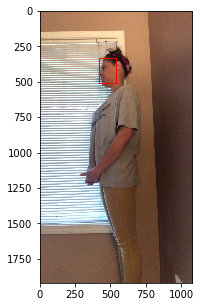

BlazeFace
Found 1 faces


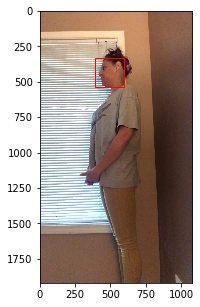

Dual Shot Face Detection
Found 1 faces


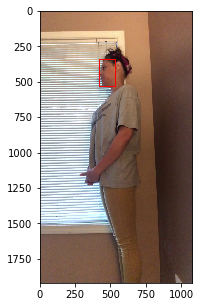

Light DSFD
Backbone: 0.0108 , FPN: 0.0018, CPM: 0.0128, Head: 0.0092, PA: 0.0003, Decode_NMS: 0.0661
Found 2 faces


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


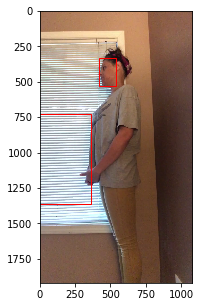

RetinaFace
Found 1 faces


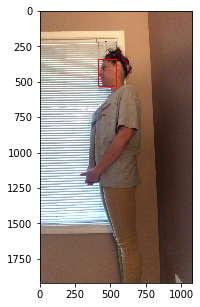

In [60]:
test_detections_on_frame(frame)

In [61]:
test_detections_on_frame()

NameError: name 'side_profile_real_frame' is not defined

For both images, all detectors worked except for BlazeFace.

It's possible that squishing the video to `128x128` is causing some problems.

It's also possible that BlazeFace isn't that great. 

## Two People

Some videos contain two people, can our detectors correctly find both people?

In [38]:
vid = mmcv.VideoReader(descrip2path('two_people_fake'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

MTCNN
Found 2 faces


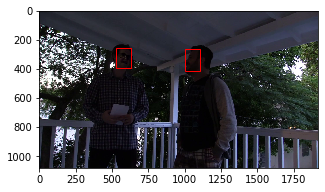

BlazeFace
Found 0 faces


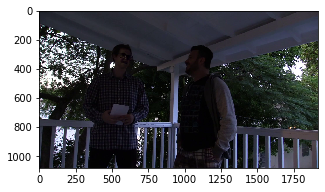

Dual Shot Face Detection
Found 2 faces


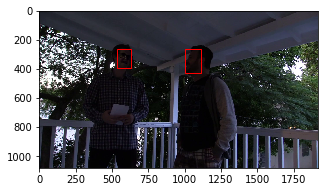

Light DSFD
Backbone: 0.0097 , FPN: 0.0021, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0601
Found 2 faces


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

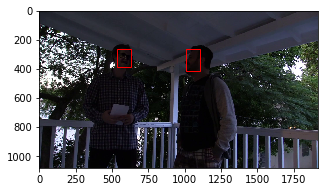

RetinaFace
Found 2 faces


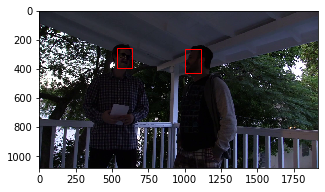

In [39]:
test_detections_on_frame(frame)

In [40]:
vid = mmcv.VideoReader(descrip2path('two_people_real'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

MTCNN
Found 2 faces


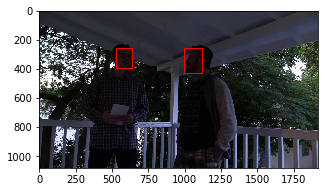

BlazeFace
Found 0 faces


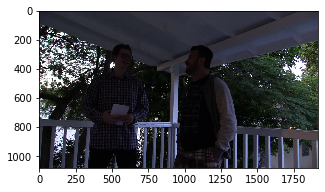

Dual Shot Face Detection
Found 2 faces


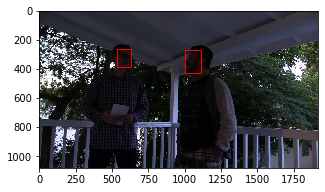

Light DSFD
Backbone: 0.0090 , FPN: 0.0018, CPM: 0.0105, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0599
Found 2 faces


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

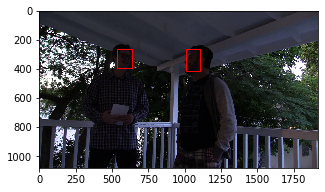

RetinaFace
Found 2 faces


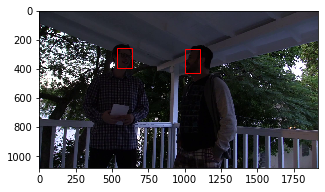

In [41]:
test_detections_on_frame(frame)

All detectors seemed to find both people.

## Very Dark Scenes

Some videos contain very dark scenes. Can we find the people in these scenes?

In [42]:
vid = mmcv.VideoReader(descrip2path('dark_scene_fake'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

MTCNN
Found 0 faces


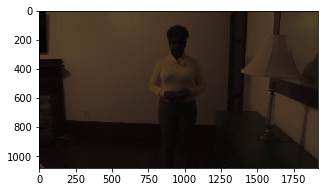

BlazeFace
Found 0 faces


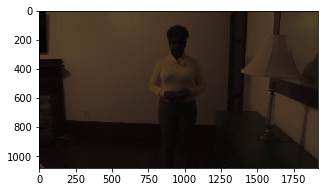

Dual Shot Face Detection
Found 1 faces


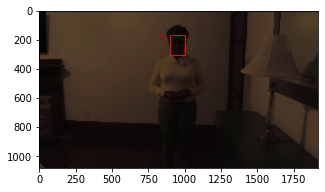

Light DSFD
Backbone: 0.0090 , FPN: 0.0020, CPM: 0.0101, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0603


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

Found 1 faces


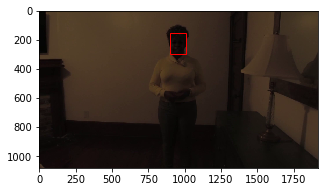

RetinaFace
Found 1 faces


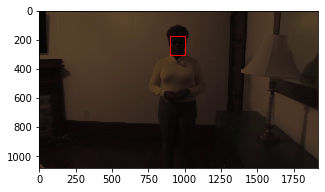

In [43]:
test_detections_on_frame(frame)

In [44]:
vid = mmcv.VideoReader(descrip2path('dark_scene_real'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

MTCNN
Found 0 faces


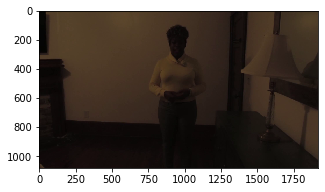

BlazeFace
Found 0 faces


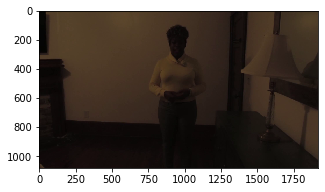

Dual Shot Face Detection
Found 1 faces


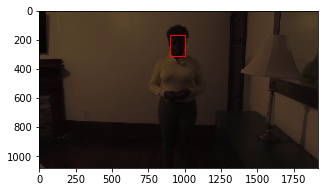

Light DSFD
Backbone: 0.0096 , FPN: 0.0020, CPM: 0.0109, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0607
Found 1 faces


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

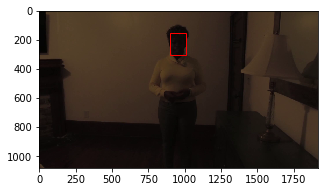

RetinaFace
Found 1 faces


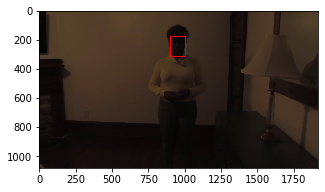

In [45]:
test_detections_on_frame(frame)

Both BlazeFace and LightDSFD have some problems.

## Moving People

Some videos contain movement, can we track the people in these vidoes? (**NOTE** This experiment doesn't demonstrate this, but I'm putting it here so you can see the video)

In [46]:
vid = mmcv.VideoReader(descrip2path('moving_fake'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

MTCNN
Found 1 faces


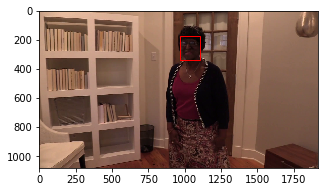

BlazeFace
Found 0 faces


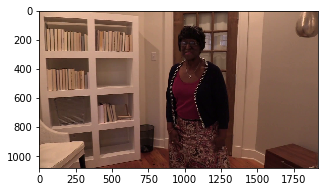

Dual Shot Face Detection
Found 1 faces


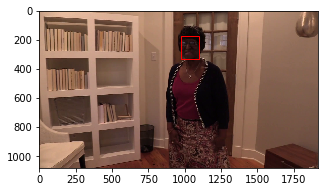

Light DSFD
Backbone: 0.0093 , FPN: 0.0021, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0586
Found 1 faces


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

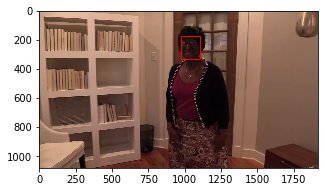

RetinaFace
Found 1 faces


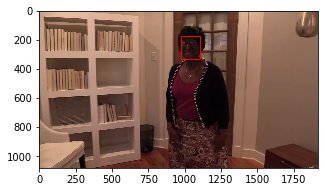

In [47]:
test_detections_on_frame(frame)

In [48]:
vid = mmcv.VideoReader(descrip2path('moving_real'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

MTCNN
Found 1 faces


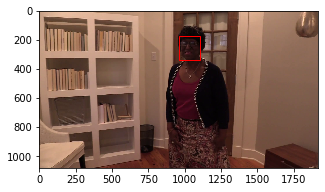

BlazeFace
Found 0 faces


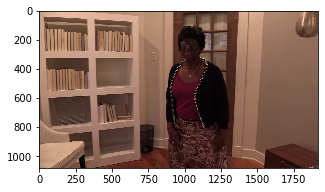

Dual Shot Face Detection
Found 1 faces


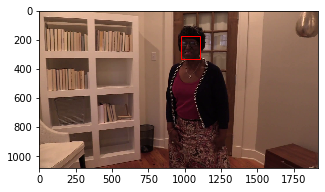

Light DSFD
Backbone: 0.0110 , FPN: 0.0024, CPM: 0.0122, Head: 0.0092, PA: 0.0003, Decode_NMS: 0.0615
Found 1 faces


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

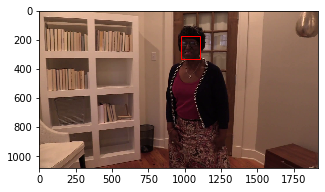

RetinaFace
Found 1 faces


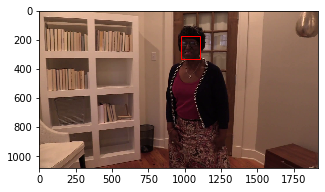

In [49]:
test_detections_on_frame(frame)

Once again BlazeFace has problems.

## Obscured Faces

Some of the Deep Fakes corrupt the faces of the individuals we're trying to find. Does this cause problems for our dectors?

In [50]:
vid = mmcv.VideoReader(descrip2path('obscured_face_fake1'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

MTCNN
Found 1 faces


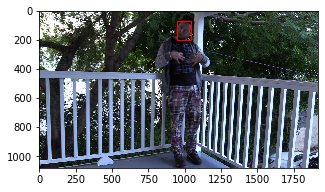

BlazeFace
Found 0 faces


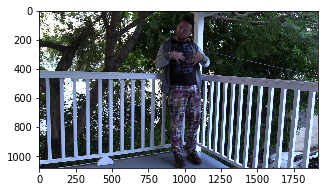

Dual Shot Face Detection
Found 1 faces


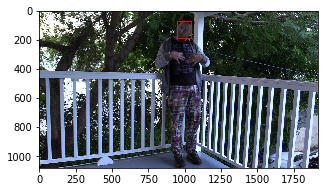

Light DSFD
Backbone: 0.0112 , FPN: 0.0022, CPM: 0.0124, Head: 0.0090, PA: 0.0003, Decode_NMS: 0.0573
Found 1 faces


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

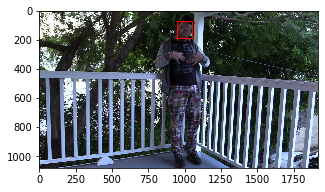

RetinaFace
Found 1 faces


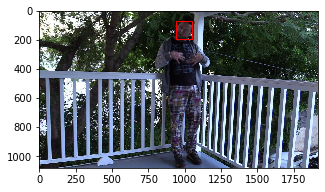

In [51]:
test_detections_on_frame(frame)

In [52]:
vid = mmcv.VideoReader(descrip2path('obscured_face_fake2'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

MTCNN
Found 1 faces


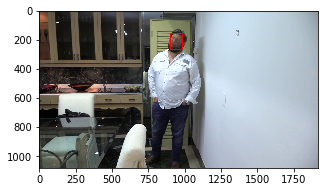

BlazeFace
Found 0 faces


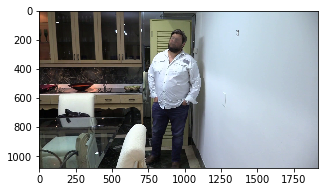

Dual Shot Face Detection
Found 1 faces


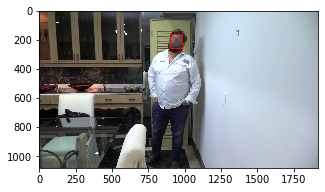

Light DSFD
Backbone: 0.0113 , FPN: 0.0022, CPM: 0.0124, Head: 0.0090, PA: 0.0003, Decode_NMS: 0.0591
Found 1 faces


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

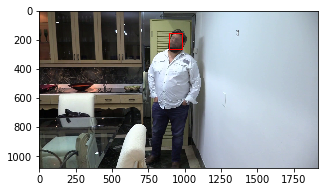

RetinaFace
Found 1 faces


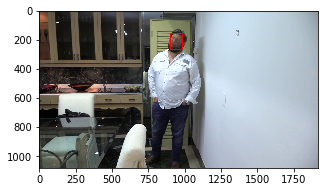

In [53]:
test_detections_on_frame(frame)

In [54]:
vid = mmcv.VideoReader(descrip2path('obscured_face_fake3'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

MTCNN
Found 1 faces


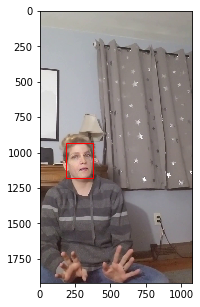

BlazeFace
Found 1 faces


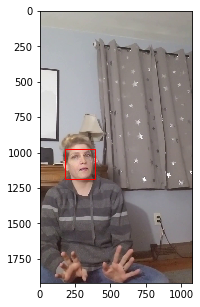

Dual Shot Face Detection
Found 1 faces


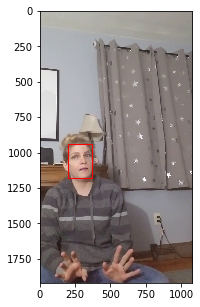

Light DSFD
Backbone: 0.0092 , FPN: 0.0021, CPM: 0.0108, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0577
Found 1 faces


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

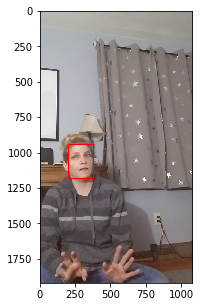

RetinaFace
Found 1 faces


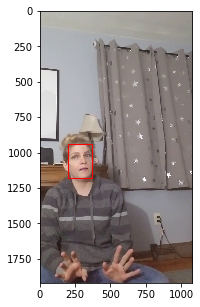

In [55]:
test_detections_on_frame(frame)

In [56]:
vid = mmcv.VideoReader(descrip2path('obscured_face_fake4'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

MTCNN
Found 1 faces


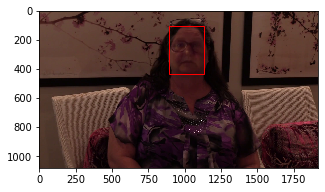

BlazeFace
Found 2 faces


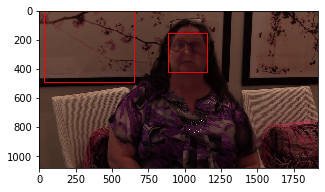

Dual Shot Face Detection
Found 1 faces


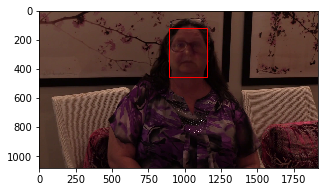

Light DSFD
Backbone: 0.0105 , FPN: 0.0021, CPM: 0.0108, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0620
Found 1 faces


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

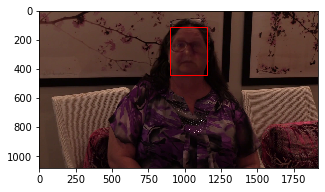

RetinaFace
Found 1 faces


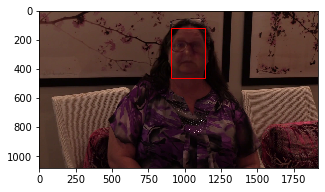

In [57]:
test_detections_on_frame(frame)

In [58]:
vid = mmcv.VideoReader(descrip2path('obscured_face_fake5'))
frame = cv2.cvtColor(next(vid), cv2.COLOR_BGR2RGB)

MTCNN
Found 1 faces


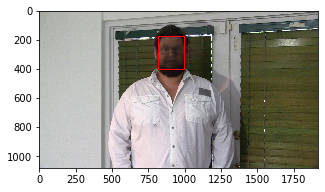

BlazeFace
Found 1 faces


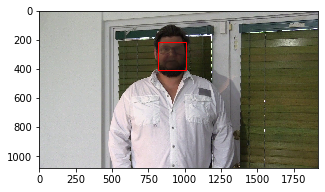

Dual Shot Face Detection
Found 1 faces


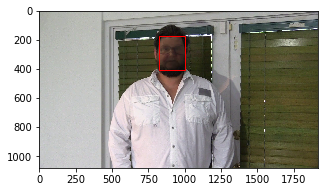

Light DSFD
Backbone: 0.0094 , FPN: 0.0021, CPM: 0.0103, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0591
Found 1 faces


/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

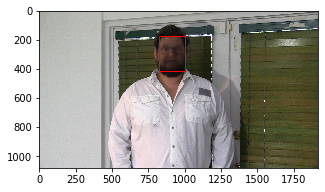

RetinaFace
Found 1 faces


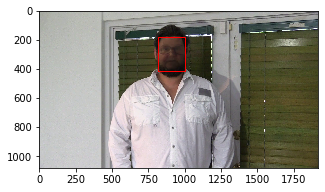

In [59]:
test_detections_on_frame(frame)

MTCNN, LightDSFD and BlazeFace all had problems.

RetinaFace and DSFD seemed to find all of the faces.

## Run Against Entire Video

So now we would like to run our detectors against entire videos and measure their performance. If a person is present in the video, I believe they are present for every frame. So we can measure the number of frames in which we detect a person and get a rough percentage out.

In [62]:
def measure_frames_with_detected_person(detector, frames, number_of_people_in_video=1):
    
    # The number of frames in which we detect the correct number of people
    number_correct = 0
    # The number of frames in which we miss one or more people
    number_missing = 0
    # The number of frames in which we detect an additional person
    number_extra = 0
    
    for frame in tqdm(frames):
        detections = detector.detect(frame)
        
        if len(detections) < number_of_people_in_video:
            number_missing = number_missing + 1
        elif len(detections) == number_of_people_in_video:
            number_correct = number_correct + 1
        else:
            number_extra = number_extra + 1
    
    return number_correct, number_missing, number_extra

In [63]:
def benchmark_detector(detector, df, record=None):
    columns = ['description', 'path', 'nface', 
               'n_correct', 'n_missing', 'n_extra', 'time']
    res = pd.DataFrame(columns=columns)
    for i, r in df.iterrows():
        if record is not None: 
            if r.path in record.path.values: continue
        all_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in mmcv.VideoReader(str(r.path))]
        tstart = time.time()
        n_correct, n_missing, n_extra = measure_frames_with_detected_person(detector, all_frames, r.nface)
        data = [r.description, r.path, r.nface, 
                n_correct, n_missing, n_extra, time.time() - tstart]
        res = res.append(pd.DataFrame([data], index=[i], columns=columns))
    return res if record is None else pd.concat([record, res])

### MTCNN

In [64]:
easyMTCNN = EasyMTCNN()

In [65]:
rn = Path('mtcnn_performance_fps15.csv')

In [66]:
record = pd.read_csv(rn) if rn.exists() else None
res_mtcnn = benchmark_detector(easyMTCNN, df, record=record)
res_mtcnn.to_csv(rn, index=False)

In [67]:
res_mtcnn

description                                              path  \
0     side_profile_fake    ../data/dfdc_train_part_0_fps15/bwsytelwkm.mp4   
1     side_profile_real    ../data/dfdc_train_part_0_fps15/fsaronfupy.mp4   
2       two_people_fake   ../data/dfdc_train_part_10_fps15/raiqyyzhrw.mp4   
3       two_people_real   ../data/dfdc_train_part_10_fps15/tvivejpzsc.mp4   
4       dark_scene_fake  ../data/train_sample_videos_fps15/cycacemkmt.mp4   
5       dark_scene_real  ../data/train_sample_videos_fps15/atvmxvwyns.mp4   
6           moving_fake    ../data/dfdc_train_part_5_fps15/lrhwwlrhjc.mp4   
7           moving_real    ../data/dfdc_train_part_5_fps15/kmigcpmqoq.mp4   
8   obscured_face_fake1   ../data/dfdc_train_part_10_fps15/qfpurllewq.mp4   
9   obscured_face_fake2    ../data/dfdc_train_part_5_fps15/wdfyezgwlx.mp4   
10  obscured_face_fake3    ../data/dfdc_train_part_5_fps15/smcelxixcs.mp4   
11  obscured_face_fake4    ../data/dfdc_train_part_5_fps15/ofxjoeebby.mp4   
12  obscured_face_fake5    ../data/dfdc_train_part_5_fps15/eiwamqjboa.mp4   
13            two faces   ../data/dfdc_train_part_10_fps15/ckzxyuvowt.mp4   

   nface n_correct n_missing n_extra       time  
0      1       152         0       0   8.273677  
1      1       152         0       0   8.076849  
2      2       118        13      21  29.376067  
3      2       109        11      32  29.476086  
4      1        91        61       0   6.763041  
5      1         3       149       0   6.358043  
6      1       125         0      27  17.119531  
7      1       125         0      27  16.472251  
8      1       100         0      52  28.098513  
9      1       132         2      18  10.966469  
10     1       150         0       2   8.789240  
11     1       138         0      14  22.676617  
12     1       152         0       0   8.172363  
13     2       126         8      18   9.966061

### BlazeFace

In [68]:
easyBlazeFace = EasyBlazeFace()

In [69]:
rn = Path('blazeface_performance_fps15.csv')

In [70]:
record = pd.read_csv(rn) if rn.exists() else None
res_blazeface = benchmark_detector(easyBlazeFace, df, record=record)
res_blazeface.to_csv(rn, index=False)

In [71]:
res_blazeface

description                                              path  \
0     side_profile_fake    ../data/dfdc_train_part_0_fps15/bwsytelwkm.mp4   
1     side_profile_real    ../data/dfdc_train_part_0_fps15/fsaronfupy.mp4   
2       two_people_fake   ../data/dfdc_train_part_10_fps15/raiqyyzhrw.mp4   
3       two_people_real   ../data/dfdc_train_part_10_fps15/tvivejpzsc.mp4   
4       dark_scene_fake  ../data/train_sample_videos_fps15/cycacemkmt.mp4   
5       dark_scene_real  ../data/train_sample_videos_fps15/atvmxvwyns.mp4   
6           moving_fake    ../data/dfdc_train_part_5_fps15/lrhwwlrhjc.mp4   
7           moving_real    ../data/dfdc_train_part_5_fps15/kmigcpmqoq.mp4   
8   obscured_face_fake1   ../data/dfdc_train_part_10_fps15/qfpurllewq.mp4   
9   obscured_face_fake2    ../data/dfdc_train_part_5_fps15/wdfyezgwlx.mp4   
10  obscured_face_fake3    ../data/dfdc_train_part_5_fps15/smcelxixcs.mp4   
11  obscured_face_fake4    ../data/dfdc_train_part_5_fps15/ofxjoeebby.mp4   
12  obscured_face_fake5    ../data/dfdc_train_part_5_fps15/eiwamqjboa.mp4   
13            two faces   ../data/dfdc_train_part_10_fps15/ckzxyuvowt.mp4   

   nface n_correct n_missing n_extra      time  
0      1       148         4       0  1.617839  
1      1       148         4       0  1.798096  
2      2         0       152       0  1.547610  
3      2         0       152       0  1.294918  
4      1         1       151       0  1.394236  
5      1         1       151       0  1.291672  
6      1         5       147       0  1.295165  
7      1         8       144       0  1.311000  
8      1        36       116       0  1.416642  
9      1         2       150       0  1.385835  
10     1       149         3       0  1.547817  
11     1        47        10      95  1.795447  
12     1       152         0       0  1.706027  
13     2         0       152       0  1.304146

### EasyDSFD

In [72]:
easyDSFD = EasyDSFD()

Finished loading model!


In [73]:
rn = Path('dsfd_performance_fps15.csv')

In [74]:
record = pd.read_csv(rn) if rn.exists() else None
res_dsfd = benchmark_detector(easyDSFD, df, record=record)
res_dsfd.to_csv(rn, index=False)

In [75]:
res_dsfd

description                                              path  \
0     side_profile_fake    ../data/dfdc_train_part_0_fps15/bwsytelwkm.mp4   
1     side_profile_real    ../data/dfdc_train_part_0_fps15/fsaronfupy.mp4   
2       two_people_fake   ../data/dfdc_train_part_10_fps15/raiqyyzhrw.mp4   
3       two_people_real   ../data/dfdc_train_part_10_fps15/tvivejpzsc.mp4   
4       dark_scene_fake  ../data/train_sample_videos_fps15/cycacemkmt.mp4   
5       dark_scene_real  ../data/train_sample_videos_fps15/atvmxvwyns.mp4   
6           moving_fake    ../data/dfdc_train_part_5_fps15/lrhwwlrhjc.mp4   
7           moving_real    ../data/dfdc_train_part_5_fps15/kmigcpmqoq.mp4   
8   obscured_face_fake1   ../data/dfdc_train_part_10_fps15/qfpurllewq.mp4   
9   obscured_face_fake2    ../data/dfdc_train_part_5_fps15/wdfyezgwlx.mp4   
10  obscured_face_fake3    ../data/dfdc_train_part_5_fps15/smcelxixcs.mp4   
11  obscured_face_fake4    ../data/dfdc_train_part_5_fps15/ofxjoeebby.mp4   
12  obscured_face_fake5    ../data/dfdc_train_part_5_fps15/eiwamqjboa.mp4   
13            two faces   ../data/dfdc_train_part_10_fps15/ckzxyuvowt.mp4   

   nface n_correct n_missing n_extra       time  
0      1       152         0       0  71.100842  
1      1       152         0       0  71.312979  
2      2       152         0       0  70.426887  
3      2       152         0       0  70.403378  
4      1       152         0       0  70.446195  
5      1       152         0       0  70.447268  
6      1       152         0       0  70.462780  
7      1       152         0       0  70.488467  
8      1       152         0       0  70.439504  
9      1       152         0       0  70.500623  
10     1       152         0       0  71.051173  
11     1       140         0      12  70.421455  
12     1       152         0       0  70.398752  
13     2       152         0       0  34.726076

### LightDSFD

In [79]:
easyLightDSFD = EasyLightDSFD()

ERROR: You specified size [1080, 1920]. However, currently only SSD640 (size=640) is supported!


In [40]:
rn = Path('lightdsfd_performance.csv')

In [41]:
if rn.exists():
    record = pd.read_csv(rn)
    res_lightdsfd = benchmark_detector(easyLightDSFD, df, record)
else:
    res_lightdsfd = benchmark_detector(easyLightDSFD, df)
    
res_lightdsfd.to_csv(rn, index=False)

/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.auto

Backbone: 0.0328 , FPN: 0.0483, CPM: 0.0156, Head: 0.0113, PA: 0.0003, Decode_NMS: 0.2404
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0100, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0115, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0639
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0108, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0104, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0098 , FPN: 0.0013, CPM: 0.0100, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0645


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0099, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0650


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0104, Head: 0.0081, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0108, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0101, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0099 , FPN: 0.0015, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0101, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0100, Head: 0.0070, PA: 0.0003, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0105, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0093 , FPN: 0.0016, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0613


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0639
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0101, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0101, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0105, Head: 0.0071, PA: 0.0003, Decode_NMS: 0.0615


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0092 , FPN: 0.0016, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0110, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0639
Backbone: 0.0094 , FPN: 0.0017, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0099, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0638
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0641
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0611


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0105, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0099, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0107, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0612


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0100, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0656
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0103, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0616


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0108, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0106, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0653
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0106, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0656
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0105, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0101, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0615


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0108, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0103, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0101, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0107, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0107, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0664
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0106, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0100, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0107, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0638
Backbone: 0.0098 , FPN: 0.0013, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0632
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0659


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0103, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0107, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0644


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0630
Backbone: 0.0088 , FPN: 0.0014, CPM: 0.0107, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0102, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0630
Backbone: 0.0087 , FPN: 0.0013, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0635
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0652


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0631
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0105, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0630
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0632
Backbone: 0.0092 , FPN: 0.0016, CPM: 0.0107, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0617


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0616


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0104, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0642
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0106, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0641
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0106, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0104, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0645


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0659


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0015, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0636
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0106, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0619


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0098, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0668
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0103, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0104, Head: 0.0079, PA: 0.0003, Decode_NMS: 0.0646


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0107, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0653
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0110, Head: 0.0081, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0108, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0662
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0106, Head: 0.0078, PA: 0.0003, Decode_NMS: 0.0647
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0638
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0107, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0103, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0639
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0110, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0656


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0105, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0103, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0646
Backbone: 0.0086 , FPN: 0.0013, CPM: 0.0099, Head: 0.0078, PA: 0.0003, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0013, CPM: 0.0107, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0103, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0638
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0104, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0618


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0106, Head: 0.0080, PA: 0.0003, Decode_NMS: 0.0646
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0113, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0106, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0086 , FPN: 0.0013, CPM: 0.0096, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0104, Head: 0.0078, PA: 0.0003, Decode_NMS: 0.0655
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0099, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0636
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0098, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0098, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0108, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0105, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0107, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0109, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0016, CPM: 0.0108, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0653


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0103, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0108, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0107, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0646
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0106, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0105, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0099, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0638
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0106, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0109, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0108, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0102, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0103, Head: 0.0078, PA: 0.0003, Decode_NMS: 0.0651
Backbone: 0.0096 , FPN: 0.0013, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0099, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0612


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0097 , FPN: 0.0013, CPM: 0.0100, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0101, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0104, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0099, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0099, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0108, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0099, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0106, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0610


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0100, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0096 , FPN: 0.0013, CPM: 0.0099, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0088 , FPN: 0.0014, CPM: 0.0098, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0104, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0101, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0652
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0108, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0107, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0105, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0112, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0632
Backbone: 0.0099 , FPN: 0.0014, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0106, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0105, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0086 , FPN: 0.0015, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0013, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0106, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0110, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0678
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0109, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0644


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0106, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0109, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0099, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0004, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0102, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0100, Head: 0.0074, PA: 0.0004, Decode_NMS: 0.0618


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0105, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0642
Backbone: 0.0096 , FPN: 0.0013, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0102, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0633



/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0107, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0649


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0103 , FPN: 0.0014, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0645


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0087 , FPN: 0.0013, CPM: 0.0102, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0662
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0104, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0646
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0098, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0108, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0101 , FPN: 0.0015, CPM: 0.0109, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0641
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0101, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0641
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0615


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0639
Backbone: 0.0098 , FPN: 0.0016, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0646
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0106, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0107, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0611


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0109, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0618


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0108, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0639
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0104, Head: 0.0078, PA: 0.0003, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0102, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0099, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0608


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0106, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0104, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0108, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0636
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0687
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0088 , FPN: 0.0015, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0017, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0639
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0101, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0099, Head: 0.0071, PA: 0.0003, Decode_NMS: 0.0643
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0101, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0618


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0108, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0101, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0634
Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0108, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0614


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0102, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0104, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0732
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0107, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0613


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0102 , FPN: 0.0014, CPM: 0.0111, Head: 0.0075, PA: 0.0004, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0106 , FPN: 0.0016, CPM: 0.0118, Head: 0.0087, PA: 0.0002, Decode_NMS: 0.0639
Backbone: 0.0112 , FPN: 0.0016, CPM: 0.0119, Head: 0.0088, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0108 , FPN: 0.0015, CPM: 0.0111, Head: 0.0085, PA: 0.0003, Decode_NMS: 0.0678
Backbone: 0.0105 , FPN: 0.0017, CPM: 0.0118, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0672


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0100 , FPN: 0.0016, CPM: 0.0117, Head: 0.0088, PA: 0.0002, Decode_NMS: 0.0694
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0111, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0670


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0017, CPM: 0.0107, Head: 0.0083, PA: 0.0002, Decode_NMS: 0.0706
Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0102, Head: 0.0083, PA: 0.0003, Decode_NMS: 0.0689


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0106, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0709
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0105, Head: 0.0084, PA: 0.0002, Decode_NMS: 0.0686


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0015, CPM: 0.0107, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0702
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0673


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0105 , FPN: 0.0014, CPM: 0.0106, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0676
Backbone: 0.0111 , FPN: 0.0015, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0102 , FPN: 0.0017, CPM: 0.0120, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0673
Backbone: 0.0105 , FPN: 0.0016, CPM: 0.0116, Head: 0.0083, PA: 0.0002, Decode_NMS: 0.0650


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0109 , FPN: 0.0017, CPM: 0.0123, Head: 0.0086, PA: 0.0002, Decode_NMS: 0.0668
Backbone: 0.0106 , FPN: 0.0017, CPM: 0.0129, Head: 0.0086, PA: 0.0002, Decode_NMS: 0.0660


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0105 , FPN: 0.0016, CPM: 0.0113, Head: 0.0086, PA: 0.0003, Decode_NMS: 0.0687
Backbone: 0.0104 , FPN: 0.0015, CPM: 0.0113, Head: 0.0085, PA: 0.0002, Decode_NMS: 0.0655


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0125, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0833
Backbone: 0.0123 , FPN: 0.0022, CPM: 0.0128, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0109, Head: 0.0100, PA: 0.0003, Decode_NMS: 0.0823
Backbone: 0.0099 , FPN: 0.0021, CPM: 0.0113, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0748
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0126, Head: 0.0108, PA: 0.0003, Decode_NMS: 0.0718


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0124, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0633
Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0105, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0685
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0662
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0103, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0106, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0627
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0102, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0015, CPM: 0.0111, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0676
Backbone: 0.0100 , FPN: 0.0015, CPM: 0.0111, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0107, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0107, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0613


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0635
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0613


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0617


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0100, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0109, Head: 0.0081, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0107, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0641
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0097, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0015, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0104, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0634
Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0616


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0104, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0640
Backbone: 0.0096 , FPN: 0.0013, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0624
Backbone: 0.0100 , FPN: 0.0015, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0639
Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0108, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0109, Head: 0.0078, PA: 0.0003, Decode_NMS: 0.0657


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0102, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0104, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0104, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0666
Backbone: 0.0095 , FPN: 0.0016, CPM: 0.0106, Head: 0.0078, PA: 0.0003, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0106, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0108, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0674
Backbone: 0.0101 , FPN: 0.0015, CPM: 0.0109, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0653


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0106, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0103, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0616


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0106, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0666
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0092 , FPN: 0.0016, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0617


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0676
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0610


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0099, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0087 , FPN: 0.0013, CPM: 0.0099, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0110, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0669
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0107, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0673
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0674
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0101, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0102, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0673
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0102, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0110, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0668
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0109, Head: 0.0081, PA: 0.0002, Decode_NMS: 0.0702
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0100 , FPN: 0.0015, CPM: 0.0108, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0109, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0613


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0015, CPM: 0.0112, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0100, Head: 0.0081, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0662
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0111, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0645


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0114, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0107, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0619
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0617


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0016, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0633
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0105, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0619


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0634
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0107, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0631
Backbone: 0.0094 , FPN: 0.0016, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0615


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0638
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0613


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0016, CPM: 0.0099, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0099, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0101, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0100, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0624
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0110, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0649


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0016, CPM: 0.0113, Head: 0.0082, PA: 0.0003, Decode_NMS: 0.0645
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0103, Head: 0.0071, PA: 0.0003, Decode_NMS: 0.0628
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0101 , FPN: 0.0014, CPM: 0.0106, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0100 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0113, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0618


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0099, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0107, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0104, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0013, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0641
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0087 , FPN: 0.0013, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0099, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0105, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0651
Backbone: 0.0092 , FPN: 0.0016, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0099 , FPN: 0.0016, CPM: 0.0109, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0101 , FPN: 0.0014, CPM: 0.0105, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0107, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0097, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0104, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0636
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0103, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0100, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0102, Head: 0.0083, PA: 0.0003, Decode_NMS: 0.0655
Backbone: 0.0094 , FPN: 0.0016, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0647


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0108, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0099 , FPN: 0.0015, CPM: 0.0109, Head: 0.0081, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0016, CPM: 0.0111, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0109, Head: 0.0084, PA: 0.0003, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0107, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0607


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0109, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0639
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0619


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0610


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0603


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0106, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0639
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0616


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0624
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0629
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0104, Head: 0.0082, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0013, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0632
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0616


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0634
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0628
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0097 , FPN: 0.0019, CPM: 0.0109, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0105, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0637
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0103, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0615


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0641
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0619


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0632
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0107, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0099, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0619


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629
Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0013, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0630
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0632



/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0099, Head: 0.0071, PA: 0.0003, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0109, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0103, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0103, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0099, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0671
Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0016, CPM: 0.0110, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0100, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0104, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0104, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0106, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0098 , FPN: 0.0013, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0014, CPM: 0.0103, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0104, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0098, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0675
Backbone: 0.0095 , FPN: 0.0016, CPM: 0.0106, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0649


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0109, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0110, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0107, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0662
Backbone: 0.0100 , FPN: 0.0015, CPM: 0.0111, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0103, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0106, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0662
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0107, Head: 0.0080, PA: 0.0003, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0106, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0660
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0648


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0016, CPM: 0.0107, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0110, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0663
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0672
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0105, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0677
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0106, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0081, PA: 0.0002, Decode_NMS: 0.0679
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0097, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0101, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0104, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0687
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0098, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0105, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0664
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0082, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0108, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0103 , FPN: 0.0015, CPM: 0.0108, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0648


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0109, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0645


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0112, Head: 0.0079, PA: 0.0003, Decode_NMS: 0.0649
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0099, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0108, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0103, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0105, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0097 , FPN: 0.0013, CPM: 0.0102, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0660


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0111, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0630
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0105, Head: 0.0083, PA: 0.0003, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0106, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0651
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0100, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0640
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0107, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0113, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0104, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0106, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0098, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0106, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0106, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0098 , FPN: 0.0013, CPM: 0.0101, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0100, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0105, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0096, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0638
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0098, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0106, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0013, CPM: 0.0106, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0108, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0104, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0103, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0105, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0645


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0109, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0099, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0106, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0097, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0105, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0014, CPM: 0.0100, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0645
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0096, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0656


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0097, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0098 , FPN: 0.0013, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0619


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0107, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0666
Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0646


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0102, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0645
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0098, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0013, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0015, CPM: 0.0107, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0626
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0109, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0645


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0110, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0664
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0100, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0109, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0646


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0104, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0653
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0013, CPM: 0.0099, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0672
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0099, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0101 , FPN: 0.0014, CPM: 0.0108, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0105, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0647


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0015, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0671
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0109, Head: 0.0083, PA: 0.0003, Decode_NMS: 0.0674
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0106, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0106, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0678
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0107, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0680
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0648


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0691
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0109, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0677
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0102, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0670
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0644


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0675
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0673
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0644


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0110, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0100, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0679
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0648


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0678
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0109, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0682
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0102, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0682
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0101, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0647


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0675
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0100, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0098, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0099, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0616


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0087 , FPN: 0.0013, CPM: 0.0097, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0105, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0097, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0679
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0099, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0644


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0110, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0678
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0099, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0644


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0671
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0096, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0619


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0100, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0683
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0108, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0107, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0678
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0103, Head: 0.0083, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0680
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0097, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0618


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0677
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0646


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0101, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0672
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0670
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0106, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0666
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0688
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0099, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0688
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0098, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0648


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0686
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0107, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0669
Backbone: 0.0097 , FPN: 0.0013, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0677
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0103, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0105, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0109, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0102, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0106, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0659


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0677
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0108, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0645


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0097, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0668
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0108, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0104, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0099, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0102, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0677
Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0111, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0100, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0686
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0100, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0087 , FPN: 0.0015, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0099, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0683
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0098, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0109, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0679
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0111, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0099, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0616


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0674
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0099, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0106, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0672
Backbone: 0.0100 , FPN: 0.0014, CPM: 0.0110, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0103, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0099, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0646


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0013, CPM: 0.0108, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0664
Backbone: 0.0090 , FPN: 0.0018, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0646


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0626
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0097, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0634
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0098, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0106, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0087 , FPN: 0.0014, CPM: 0.0101, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0107, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0100 , FPN: 0.0014, CPM: 0.0110, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0106, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0112, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0641



/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0103, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0636
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0106, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0108, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0664
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0109, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0110, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0112, Head: 0.0082, PA: 0.0003, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0111, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0107, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0102 , FPN: 0.0016, CPM: 0.0108, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0649


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0104, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0703
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0104, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0644


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0703
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0106, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0094 , FPN: 0.0016, CPM: 0.0106, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0636
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0106, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0098, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0087 , FPN: 0.0014, CPM: 0.0101, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0667
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0094 , FPN: 0.0016, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0109, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0644


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0643
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0102, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0105, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0630
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0016, CPM: 0.0098, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0106, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0108, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0104, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0659


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0674
Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0098, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0670
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0108, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0106, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0650
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0107, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0101, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0662
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0098, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0105, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0634
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0107, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0107, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0645


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0109, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0108, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0646


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0113, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0099, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0092 , FPN: 0.0016, CPM: 0.0111, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0015, CPM: 0.0110, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0111, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0657


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0114, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0648
Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0108, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0094 , FPN: 0.0016, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0096 , FPN: 0.0013, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0015, CPM: 0.0110, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0100 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0617


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0103, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0662
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0098, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0016, CPM: 0.0109, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0688
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0619


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0016, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0100, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0104, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0100, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0102, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0672
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0103, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0674
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0106, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0106, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0100, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0101, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0679
Backbone: 0.0095 , FPN: 0.0016, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0102, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0106, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0099, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0673
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0106, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0087 , FPN: 0.0013, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0668
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0664
Backbone: 0.0099 , FPN: 0.0015, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0098, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0664
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0107, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0104 , FPN: 0.0014, CPM: 0.0108, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0679
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0651


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0017, CPM: 0.0109, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0670
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0103, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0648


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0106, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0016, CPM: 0.0107, Head: 0.0081, PA: 0.0003, Decode_NMS: 0.0690
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0109, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0674
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0106, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0675
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0016, CPM: 0.0108, Head: 0.0071, PA: 0.0003, Decode_NMS: 0.0693
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0655


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0849
Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0674
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0650


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0106, Head: 0.0078, PA: 0.0003, Decode_NMS: 0.0640
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0105, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0654


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0106, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0099, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0106, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0099, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0106, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0632
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0106, Head: 0.0081, PA: 0.0002, Decode_NMS: 0.0660


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0109, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0647


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0098, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0111, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0091 , FPN: 0.0016, CPM: 0.0101, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0647


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0106, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0655
Backbone: 0.0092 , FPN: 0.0016, CPM: 0.0102, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0099, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0100 , FPN: 0.0015, CPM: 0.0110, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0112, Head: 0.0083, PA: 0.0002, Decode_NMS: 0.0646


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0107, Head: 0.0081, PA: 0.0003, Decode_NMS: 0.0657
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0105, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0106, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0103, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0657


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0110, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0103, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0631
Backbone: 0.0096 , FPN: 0.0017, CPM: 0.0114, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0107, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0654
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0670
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0106, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0682
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0105, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0681
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0103, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0653


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0104, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0099, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0668
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0676
Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0099, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0101 , FPN: 0.0014, CPM: 0.0106, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0675
Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0105, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0099, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0676
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0105, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0653


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0658


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0107, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0099, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0108, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0646


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0107, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0614


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0097, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0618
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0111, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0644


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0105, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0639
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0100, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0647
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0102, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0657


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0014, CPM: 0.0103, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0631
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0097, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0647


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0014, CPM: 0.0102, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0103, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0014, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0650


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0110, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0098 , FPN: 0.0013, CPM: 0.0105, Head: 0.0078, PA: 0.0003, Decode_NMS: 0.0646


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0105, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0652


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0108, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0644


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0641


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0017, CPM: 0.0098, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0626
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0099, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0107, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0803
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0103, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0101 , FPN: 0.0014, CPM: 0.0111, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0655


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0105, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0639
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0664
Backbone: 0.0100 , FPN: 0.0014, CPM: 0.0108, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0106, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0654


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0100, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0634
Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0103, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0109, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0097, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0634



/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0624
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0104, Head: 0.0076, PA: 0.0004, Decode_NMS: 0.0651
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0616


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0616


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0610


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0106, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0607


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0106, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0664
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0614


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0670
Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0108, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0666
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0107, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0108, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0102 , FPN: 0.0015, CPM: 0.0107, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0108, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0016, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0100 , FPN: 0.0015, CPM: 0.0107, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0638


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0108, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0664
Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0617


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0014, CPM: 0.0109, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0088 , FPN: 0.0014, CPM: 0.0104, Head: 0.0081, PA: 0.0003, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0664
Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0104, Head: 0.0078, PA: 0.0003, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0080, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0662
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0108, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0113, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0670
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0099, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0656
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0101, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0106, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0664
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0107, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0106, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0658
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0105, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0088 , FPN: 0.0014, CPM: 0.0098, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0107, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0104, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0660
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0108, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0099 , FPN: 0.0014, CPM: 0.0100, Head: 0.0079, PA: 0.0003, Decode_NMS: 0.0648
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0636
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0099, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0105, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0639
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0092 , FPN: 0.0016, CPM: 0.0102, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0612


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0109, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0097 , FPN: 0.0016, CPM: 0.0108, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0642
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0618


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0619


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0112, Head: 0.0082, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0616


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0103, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0653
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0101, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0614


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0630
Backbone: 0.0097 , FPN: 0.0013, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0100 , FPN: 0.0016, CPM: 0.0109, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0100 , FPN: 0.0015, CPM: 0.0110, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0102 , FPN: 0.0016, CPM: 0.0108, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0666
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0111, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0639


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0108, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0689
Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0107, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0015, CPM: 0.0107, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0672
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0676
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0106, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0688
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0641
Backbone: 0.0095 , FPN: 0.0017, CPM: 0.0104, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0100, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0106, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0106, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0666
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0100, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0771


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0140 , FPN: 0.0014, CPM: 0.0103, Head: 0.0086, PA: 0.0002, Decode_NMS: 0.0705
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0154, Head: 0.0087, PA: 0.0002, Decode_NMS: 0.0744


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0110 , FPN: 0.0014, CPM: 0.0117, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0716
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0713


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0101, Head: 0.0082, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0097 , FPN: 0.0019, CPM: 0.0141, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0619


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0110 , FPN: 0.0023, CPM: 0.0165, Head: 0.0102, PA: 0.0002, Decode_NMS: 0.0631
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0688


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0138, Head: 0.0120, PA: 0.0002, Decode_NMS: 0.0766
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0673


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0124, Head: 0.0117, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0144 , FPN: 0.0023, CPM: 0.0114, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0727


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0101, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0110, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0107, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0646
Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0619


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0627
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0108, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0641
Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0101, Head: 0.0077, PA: 0.0003, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0647
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0104, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0087 , FPN: 0.0014, CPM: 0.0101, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0652
Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0108, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0016, CPM: 0.0099, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0611


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0644


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0618


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0640
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0641
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0109, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0635
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0107, Head: 0.0078, PA: 0.0003, Decode_NMS: 0.0645


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0016, CPM: 0.0104, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0695
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0648
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0641
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0615


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0632
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0606


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0636
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0625


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0108, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0632
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0617


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0630
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0622
Backbone: 0.0091 , FPN: 0.0013, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0667
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0613


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0015, CPM: 0.0105, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0624
Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0614


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0103, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0652
Backbone: 0.0094 , FPN: 0.0016, CPM: 0.0108, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0016, CPM: 0.0098, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0112, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0112, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0100 , FPN: 0.0014, CPM: 0.0109, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0109, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0641
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0110, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0657
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0015, CPM: 0.0101, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0625
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0103, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0612


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0108, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0649
Backbone: 0.0101 , FPN: 0.0014, CPM: 0.0106, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0106, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0645
Backbone: 0.0089 , FPN: 0.0015, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0102, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0653
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0101, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0102, Head: 0.0082, PA: 0.0003, Decode_NMS: 0.0672
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0015, CPM: 0.0106, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0672
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0098, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0636


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0111, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0676
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0108, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0623


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0105, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0656
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0108, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0103, Head: 0.0082, PA: 0.0003, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0656
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0105, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0095 , FPN: 0.0016, CPM: 0.0103, Head: 0.0081, PA: 0.0003, Decode_NMS: 0.0648
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0099, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0654
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0016, CPM: 0.0106, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0013, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0105, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0614


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0657
Backbone: 0.0095 , FPN: 0.0013, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0626


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0106, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0655
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0107, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0017, CPM: 0.0100, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0664
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0104, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0671
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0108, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0646


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0103, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0013, CPM: 0.0110, Head: 0.0075, PA: 0.0003, Decode_NMS: 0.0677
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0110, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0642


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0101, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0666
Backbone: 0.0096 , FPN: 0.0016, CPM: 0.0105, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0099 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0003, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0111, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0098, Head: 0.0076, PA: 0.0003, Decode_NMS: 0.0668
Backbone: 0.0100 , FPN: 0.0016, CPM: 0.0106, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0629


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0662
Backbone: 0.0095 , FPN: 0.0016, CPM: 0.0109, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0637


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0099, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0015, CPM: 0.0104, Head: 0.0070, PA: 0.0002, Decode_NMS: 0.0661
Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0632


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0015, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0650
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0108, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0630


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0098 , FPN: 0.0014, CPM: 0.0099, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0668
Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0106, Head: 0.0078, PA: 0.0003, Decode_NMS: 0.0648
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0106, Head: 0.0071, PA: 0.0002, Decode_NMS: 0.0628


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0013, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0107, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0644


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0646
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0104, Head: 0.0072, PA: 0.0003, Decode_NMS: 0.0635


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0107, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0651
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0633


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0090 , FPN: 0.0015, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0638
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0100, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0099, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0658
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0111, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0627


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0104, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0106, Head: 0.0074, PA: 0.0003, Decode_NMS: 0.0631


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0105, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0668
Backbone: 0.0095 , FPN: 0.0014, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0640


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0107, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0660
Backbone: 0.0100 , FPN: 0.0016, CPM: 0.0107, Head: 0.0077, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0665
Backbone: 0.0090 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0622


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0659
Backbone: 0.0090 , FPN: 0.0013, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0624


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0099, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0637
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0106, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0634


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0087 , FPN: 0.0013, CPM: 0.0102, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0647
Backbone: 0.0088 , FPN: 0.0013, CPM: 0.0098, Head: 0.0072, PA: 0.0002, Decode_NMS: 0.0612


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0089 , FPN: 0.0014, CPM: 0.0103, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0627
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0610


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0101, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0663
Backbone: 0.0099 , FPN: 0.0015, CPM: 0.0104, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0643


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0016, CPM: 0.0104, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0639
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0101, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0621


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0099, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0633
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0617


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0111, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0677
Backbone: 0.0093 , FPN: 0.0013, CPM: 0.0102, Head: 0.0073, PA: 0.0002, Decode_NMS: 0.0616


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0013, CPM: 0.0102, Head: 0.0075, PA: 0.0002, Decode_NMS: 0.0638
Backbone: 0.0091 , FPN: 0.0014, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0608


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0100, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0636
Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0613


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0015, CPM: 0.0102, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0632
Backbone: 0.0097 , FPN: 0.0014, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0620


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0092 , FPN: 0.0014, CPM: 0.0108, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0643
Backbone: 0.0091 , FPN: 0.0015, CPM: 0.0103, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0617


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0093 , FPN: 0.0014, CPM: 0.0104, Head: 0.0074, PA: 0.0002, Decode_NMS: 0.0639
Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0109, Head: 0.0078, PA: 0.0002, Decode_NMS: 0.0617



/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0014, CPM: 0.0101, Head: 0.0079, PA: 0.0002, Decode_NMS: 0.0644
Backbone: 0.0096 , FPN: 0.0014, CPM: 0.0106, Head: 0.0076, PA: 0.0002, Decode_NMS: 0.0645


/opt/conda/conda-bld/pytorch_1579022060824/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Backbone: 0.0094 , FPN: 0.0015, CPM: 0.0110, Head: 0.0082, PA: 0.0002, Decode_NMS: 0.0657



ValueError: not enough values to unpack (expected 2, got 0)

### RetinaFace

In [76]:
easyRetinaFace = EasyRetinaFace()

Loading pretrained model from Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456


In [77]:
rn = Path('retinaface_performance_fps15.csv')

In [78]:
record = pd.read_csv(rn) if rn.exists() else None
res_retinaface = benchmark_detector(easyRetinaFace, df, record=record)
res_retinaface.to_csv(rn, index=False)

In [79]:
res_retinaface

description                                              path  \
0     side_profile_fake    ../data/dfdc_train_part_0_fps15/bwsytelwkm.mp4   
1     side_profile_real    ../data/dfdc_train_part_0_fps15/fsaronfupy.mp4   
2       two_people_fake   ../data/dfdc_train_part_10_fps15/raiqyyzhrw.mp4   
3       two_people_real   ../data/dfdc_train_part_10_fps15/tvivejpzsc.mp4   
4       dark_scene_fake  ../data/train_sample_videos_fps15/cycacemkmt.mp4   
5       dark_scene_real  ../data/train_sample_videos_fps15/atvmxvwyns.mp4   
6           moving_fake    ../data/dfdc_train_part_5_fps15/lrhwwlrhjc.mp4   
7           moving_real    ../data/dfdc_train_part_5_fps15/kmigcpmqoq.mp4   
8   obscured_face_fake1   ../data/dfdc_train_part_10_fps15/qfpurllewq.mp4   
9   obscured_face_fake2    ../data/dfdc_train_part_5_fps15/wdfyezgwlx.mp4   
10  obscured_face_fake3    ../data/dfdc_train_part_5_fps15/smcelxixcs.mp4   
11  obscured_face_fake4    ../data/dfdc_train_part_5_fps15/ofxjoeebby.mp4   
12  obscured_face_fake5    ../data/dfdc_train_part_5_fps15/eiwamqjboa.mp4   
13            two faces   ../data/dfdc_train_part_10_fps15/ckzxyuvowt.mp4   

   nface n_correct n_missing n_extra       time  
0      1       152         0       0  43.771722  
1      1       152         0       0  43.426310  
2      2       152         0       0  41.739759  
3      2       152         0       0  41.659005  
4      1       152         0       0  43.414568  
5      1       152         0       0  43.270089  
6      1       152         0       0  41.720855  
7      1       152         0       0  43.431772  
8      1       152         0       0  43.180018  
9      1       152         0       0  41.332441  
10     1       152         0       0  41.096161  
11     1       151         1       0  41.255461  
12     1       152         0       0  43.035826  
13     2       152         0       0  42.442138

### Summary

In [80]:
def summarise_performance(record, show_pct=True, video_avg=True, description=True):
    cols_n = ['n_correct', 'n_missing', 'n_extra']
    colt_t = ['time']
    df = record[cols_n].copy()
    if show_pct: 
        df['nframe'] = df.sum(axis=1).astype(np.int32)
        df = df.apply(lambda o: o / o.nframe, axis=1)
        df.drop('nframe', axis=1, inplace=True)
    df['time'] = record[colt_t].copy()
    if video_avg: df = pd.DataFrame(df.mean(axis=0)).T
    else:
        if description: df['description'] = record.description.copy()
    return df

In [81]:
summarise_performance(res_retinaface, show_pct=True, video_avg=False, description=True)

n_correct  n_missing  n_extra       time          description
0    1.000000   0.000000      0.0  43.771722    side_profile_fake
1    1.000000   0.000000      0.0  43.426310    side_profile_real
2    1.000000   0.000000      0.0  41.739759      two_people_fake
3    1.000000   0.000000      0.0  41.659005      two_people_real
4    1.000000   0.000000      0.0  43.414568      dark_scene_fake
5    1.000000   0.000000      0.0  43.270089      dark_scene_real
6    1.000000   0.000000      0.0  41.720855          moving_fake
7    1.000000   0.000000      0.0  43.431772          moving_real
8    1.000000   0.000000      0.0  43.180018  obscured_face_fake1
9    1.000000   0.000000      0.0  41.332441  obscured_face_fake2
10   1.000000   0.000000      0.0  41.096161  obscured_face_fake3
11   0.993421   0.006579      0.0  41.255461  obscured_face_fake4
12   1.000000   0.000000      0.0  43.035826  obscured_face_fake5
13   1.000000   0.000000      0.0  42.442138            two faces

In [82]:
name_records = [('mtcnn', res_mtcnn), ('blazeface', res_blazeface), 
                ('dsfd', res_dsfd), ('retinaface', res_retinaface)]

pd.concat([summarise_performance(record) for _, record in name_records],
          keys=[name for name, _ in name_records])

n_correct  n_missing   n_extra       time
mtcnn      0   0.786184   0.114662  0.099154  15.041772
blazeface  0   0.327538   0.627820  0.044643   1.479032
dsfd       0   0.994361   0.000000  0.005639  68.044741
retinaface 0   0.999530   0.000470  0.000000  42.484009